In [1]:
import torch
from torch.autograd import Variable


import random
import numpy as np
from matplotlib import pyplot as plt
import math, os

from models.vae import VAE

import h5py
from helpers.synthetic_anomalies import create_cube_mask


In [2]:
import sys
# For the patch blending we import from another directory
sys.path.append('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/git_repos/many-tasks-make-light-work')
from multitask_method.tasks.patch_blending_task import TestPatchInterpolationBlender, \
    TestPoissonImageEditingMixedGradBlender, TestPoissonImageEditingSourceGradBlender, TestCutPastePatchBlender

from multitask_method.tasks.labelling import FlippedGaussianLabeller
from multitask_method.tasks.cutout_task import Cutout


labeller = FlippedGaussianLabeller(0.2)

### Testing network

We want to see if we can overfit using the Poisson mixing on just a single image with the same anomaly as well 


The second thing we can do is test with the cut and paste technique 

In [3]:
data = h5py.File('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection/data/train_masked_sliced_images_from_0_to_35.hdf5', 'r')
data.keys()
images = data['sliced_images_train']

In [4]:
test_image = images[150]
# transpose to channels first
test_image = np.transpose(test_image, (3, 0, 1, 2))
print(test_image.shape)
#plt.imshow(test_image[:,:,3,1])
# Apply deformation on image

random_id = 1418 # random.randrange(images.shape[0])
print(random_id)
image_to_blend = images[random_id]
image_to_blend = np.transpose(image_to_blend, (3, 0, 1, 2))
#print(image_to_blend.shape)
#
## We are going to mix the channels for the image to blend in order to have more variation
## Get the number of channels
#num_channels = image_to_blend.shape[0]
#
## Generate a random permutation of channel indices
#channel_indices = np.random.permutation(num_channels)
#
## Permute the channels using the generated indices
#image_to_blend = image_to_blend[channel_indices, :, :, :]

# Create anomaly mask
mask_blending = create_cube_mask((32,32,24), WH= 20, depth= 12,  inside=True).astype(np.bool8)



(4, 32, 32, 24)
1418


In [5]:
cutout_task = Cutout(labeller)
cutpaste_task = TestCutPastePatchBlender(labeller, image_to_blend, mask_blending)
patch_interp_task = TestPatchInterpolationBlender(labeller, image_to_blend, mask_blending)
poisson_image_editing_mixed_task = TestPoissonImageEditingMixedGradBlender(labeller, image_to_blend, mask_blending)
poisson_image_editing_source_task = TestPoissonImageEditingSourceGradBlender(labeller, image_to_blend, mask_blending)

In [9]:
anom_image, anom_mask = poisson_image_editing_mixed_task(test_image, mask_blending)
pos = anom_mask[anom_mask > 0]
print(pos.mean(), pos.std(), pos.min(), pos.max())
print(np.unique(np.where(anom_image != test_image)[-1]))

0.011855892 0.03340649 2.4080276e-05 0.26440036
[ 4  5  6  7  8  9 10 11 12 13 14 15 16]


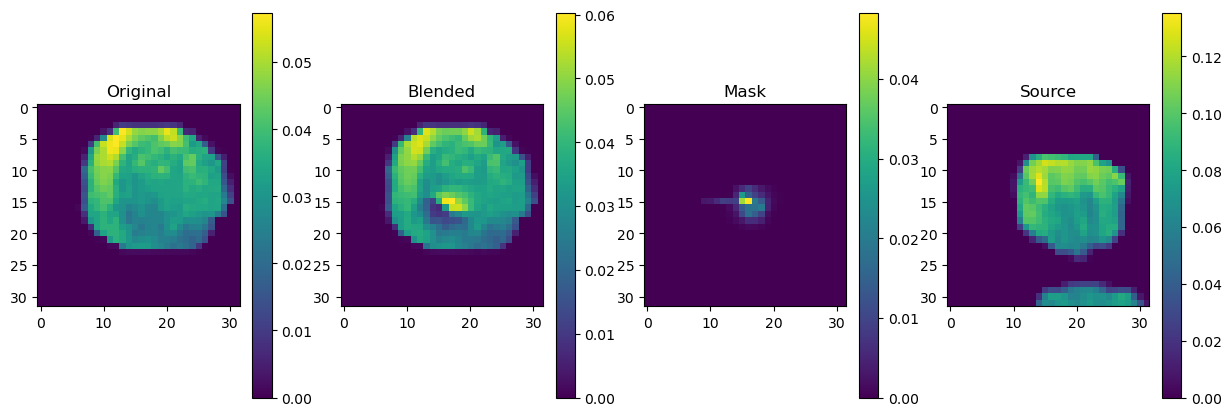

In [11]:

fig, ax = plt.subplots(1, 4, figsize=(15, 5))
t = 12
c = 0

im1 = ax[0].imshow(test_image[c,:,:,t])
ax[0].set_title('Original')
plt.colorbar(im1, ax=ax[0])
im2 = ax[1].imshow(anom_image[c,:,:,t])
ax[1].set_title('Blended')
plt.colorbar(im2, ax=ax[1])
im3 = ax[2].imshow(anom_mask[:,:,t])
ax[2].set_title('Mask')
plt.colorbar(im3, ax=ax[2])
im4 = ax[3].imshow(image_to_blend[c,:,:,t])
ax[3].set_title('Source')
plt.colorbar(im4, ax=ax[3])


In [12]:
# Repeat the image on the batch dimension
test_image = np.repeat(test_image[np.newaxis,...], 32, axis=0)
anom_mask = np.repeat(anom_mask[np.newaxis,...], 32, axis=0)
input_image = torch.from_numpy(test_image).float()
label = torch.from_numpy(anom_mask).float().unsqueeze(1)
input_image.shape, label.shape  

(torch.Size([32, 4, 32, 32, 24]), torch.Size([32, 1, 32, 32, 24]))

model = VAE(in_channels=4, gf_dim=8, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

criterion = torch.nn.BCEWithLogitsLoss()
# Create training loop
model.train()

for epoch in range(150):
    #print(f'Epoch {epoch}')

    optimizer.zero_grad()
    output_dict = model(input_image)
    loss = criterion(output_dict['decoder_output'], label)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss: {loss.item()}')
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        for i in range(5):
        
            mask_1 = ax[0,i].imshow(torch.sigmoid(output_dict['decoder_output'])[0,0,:,:,i+4].detach().numpy())
            fig.colorbar(mask_1, ax=ax[0,i])
            im = ax[1,i].imshow(anom_mask[0,:,:,i+4])
            fig.colorbar(im, ax=ax[1,i])
        # Add colorbar
        plt.show()

    


In [21]:
# model 
import torch 
import torch.nn as nn
import torch.nn.functional as F
class ResBlockDown(nn.Module):
    def __init__(self, filters_in, filters_out, act=True, stride = (2,2,2), apply_initialization = False):
        super(ResBlockDown, self).__init__()
        self.conv1 = nn.Conv3d(filters_in, filters_in, kernel_size=(3, 3, 3), stride=stride, padding=1)
        self.bn1 = nn.BatchNorm3d(filters_in)
        self.conv2 = nn.Conv3d(filters_in, filters_out, kernel_size=(3, 3, 3), padding=1)
        self.bn2 = nn.BatchNorm3d(filters_out)
        self.conv3 = nn.Conv3d(filters_in, filters_out, kernel_size=(3, 3, 3), stride=stride, padding=1)
        self.bn3 = nn.BatchNorm3d(filters_out)
        self.act = act
        if self.act:
            self.activation = nn.LeakyReLU(0.2)
        else:
            self.activation = nn.Identity()

        if apply_initialization:
            # Initialize weights and biases
            for module in [self.conv1, self.conv2, self.conv3]:
                if isinstance(module, nn.Conv3d):
                    nn.init.normal_(module.weight, mean=0.0, std=0.02)
                    nn.init.zeros_(module.bias)
                elif isinstance(module, nn.BatchNorm3d):
                    nn.init.normal_(module.weight, mean=1.0, std=0.02)
                    nn.init.zeros_(module.bias)

    def forward(self, inputs):
        conv1_out = self.conv1(inputs)
        bn1_out = self.bn1(conv1_out)
        act1_out = self.activation(bn1_out)

        conv2_out = self.conv2(act1_out)
        bn2_out = self.bn2(conv2_out)
        act2_out = self.activation(bn2_out)

        conv3_out = self.conv3(inputs)
        bn3_out = self.bn3(conv3_out)
        act3_out = self.activation(bn3_out)

        conv_out = act2_out + act3_out

        return conv_out
    

class ResBlockUp_interpolate(nn.Module):
    def __init__(self, filters_in, filters_out, act=True, scale_factor =(2,2,2), output_padding = (1,1,1)):
        super(ResBlockUp_interpolate, self).__init__()

        self.conv1 = nn.Conv3d(filters_in, filters_in, kernel_size=(3, 3, 3), padding=1)
        self.bn1 = nn.BatchNorm3d(filters_in)
        self.conv2 = nn.Conv3d(filters_in, filters_out, kernel_size=(3, 3, 3), padding=1)
        self.bn2 = nn.BatchNorm3d(filters_out)
        self.conv3 = nn.Conv3d(filters_in, filters_out, kernel_size=(3, 3, 3), padding=1)
        self.bn3 = nn.BatchNorm3d(filters_out)

        if act:
            self.activation = nn.LeakyReLU(0.2)
        else:
            self.activation = nn.Identity()

        # Initialize weights and biases
        for module in [self.conv1, self.conv2, self.conv3]:
            if isinstance(module, nn.Conv3d):
                nn.init.normal_(module.weight, mean=0.0, std=0.02)
                nn.init.zeros_(module.bias)
            elif isinstance(module, nn.BatchNorm3d):
                nn.init.normal_(module.weight, mean=1.0, std=0.02)
                nn.init.zeros_(module.bias)
        self.scale_factor = scale_factor

    def forward(self, inputs):
        # 256,2,2,3
        # Interpolate
        inputs_ = F.interpolate(inputs, scale_factor=self.scale_factor, mode='nearest')
        conv1_out = self.conv1(inputs_)
        bn1_out = self.bn1(conv1_out)
        act1_out = self.activation(bn1_out)

        conv2_out = self.conv2(act1_out)
        bn2_out = self.bn2(conv2_out)
        act2_out = self.activation(bn2_out)

        inputs_ = F.interpolate(inputs, scale_factor=self.scale_factor, mode='nearest')
        conv3_out = self.conv3(inputs_)
        bn3_out = self.bn3(conv3_out)
        act3_out = self.activation(bn3_out)

        conv_out = act2_out + act3_out

        return conv_out
class Encoder(nn.Module):
    def __init__(self, in_channels:int, gf_dim:int = 8, z_dim:int = 3072, apply_initialization = False) -> None:
        super(Encoder, self).__init__()
        self.gf_dim = gf_dim
        

        # 1st Conv block
        self.conv1 = nn.Conv3d(in_channels, gf_dim, kernel_size=(3, 3, 3), padding=1)
        self.bn1 = nn.BatchNorm3d(gf_dim)
        self.relu1 = nn.LeakyReLU(0.2)

        # Res-Blocks
        self.res1 = ResBlockDown(gf_dim, gf_dim, stride=(2,2,2))
        self.res2 = ResBlockDown(gf_dim, gf_dim * 2, stride=(2,2,2))
        self.res3 = ResBlockDown(gf_dim * 2, gf_dim * 4, stride=(2,2,2))
        self.res4 = ResBlockDown(gf_dim * 4, gf_dim * 8, stride=(2,2,1))

        # Latent Convolution layers
        self.conv_latent = nn.Conv3d(gf_dim * 8, gf_dim * 32, kernel_size=(1, 1, 1), padding=0)
        self.conv_latent_std = nn.Conv3d(gf_dim * 8, gf_dim * 32, kernel_size=(1, 1, 1), padding=0)

        # Last Linear layer
        # The image size (x,y,t) is 2x2x3 and channels depends on gf_dim 
        self.linear_latent = nn.Linear(gf_dim * 32 * 2*2*3, z_dim)

        # Convolution block
        self.conv2 = nn.Conv3d(gf_dim, gf_dim, kernel_size=(3, 3, 3), dilation=2, padding=2)
        self.bn2 = nn.BatchNorm3d(gf_dim)
        self.relu2 = nn.LeakyReLU(0.2)

        # Convolution block
        self.conv3 = nn.Conv3d(gf_dim, gf_dim * 2, kernel_size=(3, 3, 3), dilation=2, padding=2)
        self.bn3 = nn.BatchNorm3d(gf_dim * 2)
        self.relu3 = nn.LeakyReLU(0.2)

        # Convolution block
        self.conv4 = nn.Conv3d(gf_dim * 2, gf_dim, kernel_size=(3, 3, 3), dilation=2, padding=2)
        self.bn4 = nn.BatchNorm3d(gf_dim)
        self.relu4 = nn.LeakyReLU(0.2)

        # Convolution block
        self.conv5 = nn.Conv3d(gf_dim, 1, kernel_size=(3, 3, 3), dilation=2, padding=2)

        if apply_initialization: 
            # Initialization
            w_init = torch.nn.init.normal_
            b_init = torch.nn.init.constant_
            gamma_init = torch.nn.init.normal_
            for m in self.modules():
                if isinstance(m, nn.Conv3d):
                    w_init(m.weight, mean=0.0, std=0.01)
                    b_init(m.bias, val=0.0)
                elif isinstance(m, nn.BatchNorm3d):
                    gamma_init(m.weight, mean=0.5, std=0.01)    

    def forward(self, x):
        conv1 = self.conv1(x)
        conv1 = self.bn1(conv1)
        conv1 = self.relu1(conv1)

        res1 = self.res1(conv1)
        res2 = self.res2(res1)
        res3 = self.res3(res2)
        res4 = self.res4(res3)

        conv_latent = self.conv_latent(res4)
        conv_latent_std = self.conv_latent_std(res4)

        # TODO: Add linear layer
        #linear_latent = self.linear_latent(res4.view(res4.size(0), -1))
        #linear_latent_std = self.linear_latent(res4.view(res4.size(0), -1))

        conv2 = self.conv2(conv1)
        conv2 = self.bn2(conv2)
        conv2 = self.relu2(conv2)

        conv3 = self.conv3(conv2)
        conv3 = self.bn3(conv3)
        conv3 = self.relu3(conv3)

        conv4 = self.conv4(conv3)
        conv4 = self.bn4(conv4)
        conv4 = self.relu4(conv4)

        conv5 = self.conv5(conv4)
        # ====================================
        # Print shapes at various layers in the encoder network
        # ====================================
        """
        print('===================== ENCODER NETWORK ====================== ')
        print('Shape of input: ' + str(x.shape))
        print('Shape after 1st convolution block: ' + str(conv1.shape))
        print('Shape after 1st res block: ' + str(res1.shape))
        print('Shape after 2nd res block: ' + str(res2.shape))
        print('Shape after 3rd res block: ' + str(res3.shape))
        print('Shape after 4th res block: ' + str(res4.shape))
        print('-------------------------------------------------')
        print('Shape of latent_Mu: ' + str(conv_latent.shape))
        print('Shape of latent_stddev: ' + str(conv_latent_std.shape))
        print('-------------------------------------------------')
        print('=========================================================== ')
        """

        return conv_latent, conv_latent_std, conv5
class Decoder_interpolate(nn.Module):
    def __init__(self, gf_dim = 8, out_channels = 4, apply_initialization = False):
        super(Decoder_interpolate, self).__init__()
        
        self.gf_dim = gf_dim
        print(gf_dim)

        # Initialization
        #w_init = nn.init.trunc_normal_
        #b_init = nn.init.constant_
        #gamma_init = nn.init.ones_

        # Res-Blocks (for effective deep architecture)
        self.resp1 = ResBlockUp_interpolate(gf_dim * 32, gf_dim * 16, scale_factor=(2,2,1), output_padding = (1,1,0))
        self.res0 = ResBlockUp_interpolate(gf_dim * 16, gf_dim * 8, scale_factor=(2,2,2), output_padding = (1,1,1))
        self.res1 = ResBlockUp_interpolate(gf_dim * 8, gf_dim * 4, scale_factor=(2,2,2), output_padding = (1,1,1))
        self.res2 = ResBlockUp_interpolate(gf_dim * 4, gf_dim * 2, scale_factor=(2,2,2), output_padding = (1,1,1))
        #self.resp1 = ResBlockUp_interpolate(gf_dim * 8, gf_dim * 4, scale_factor=(2,2,1), output_padding = (1,1,0))
        #self.res0 = ResBlockUp_interpolate(gf_dim * 4, gf_dim * 2, scale_factor=(2,2,2), output_padding = (1,1,1))
        #self.res1 = ResBlockUp_interpolate(gf_dim * 2, gf_dim, scale_factor=(2,2,2), output_padding = (1,1,1))
        #self.res2 = ResBlockUp_interpolate(gf_dim, gf_dim, scale_factor=(2,2,2), output_padding = (1,1,1))

        # 1st convolution block: convolution, followed by batch normalization and activation
        self.conv1 = nn.Conv3d(gf_dim * 2, gf_dim, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm3d(gf_dim)
        if apply_initialization:
            self.conv1.apply(self._initialize_weights)

        # 2nd convolution block: convolution
        self.conv2 = nn.Conv3d(gf_dim, out_channels, kernel_size=3, stride=1, padding=1)
        if apply_initialization:
            self.conv2.apply(self._initialize_weights)



    def forward(self, x):
        #print(' Input to decoder has the following shape:' + str(x.shape))
        # Res-Blocks (for effective deep architecture)
        resp1 = self.resp1(x)
        res0 = self.res0(resp1)
        res1 = self.res1(res0)
        res2 = self.res2(res1)

        # 1st convolution block: convolution, followed by batch normalization and activation
        conv1 = self.conv1(res2)
        conv1 = self.bn1(conv1)
        conv1 = F.leaky_relu(conv1, 0.2)

        # 2nd convolution block: convolution
        conv2 = self.conv2(conv1)
        """
        print('===================== DECODER NETWORK ====================== ')
            
        print('Shape of input: ' + str(x.shape))
                    
        #print('Shape after 1st convolution block: ' + str(resp1.shape))
                    
        print('Shape after 1st res block: ' + str(resp1.shape))
                    
        print('Shape after 2nd res block: ' + str(res0.shape))
                    
        print('Shape after 3rd res block: ' + str(res1.shape))
                    
        print('Shape after 4th res block: ' + str(res2.shape))
                    
        #print('Shape after 5th res block: ' + str(res4.shape))
                    
        print('-------------------------------------------------')
                    
        print('Shape after 1st convolution ' + str(conv1.shape))
                    
        print('Shape of output of decoder' + str(conv2.shape))
                    
        print('-------------------------------------------------')
                    
        print('=========================================================== ')
        """

        

        return conv2
    
    def _initialize_weights(self, m):
        if isinstance(m, nn.Conv3d):
            nn.init.trunc_normal_(m.weight, std=0.01)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)
        elif isinstance(m, nn.BatchNorm3d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)



class VAE_interpolate(nn.Module):
    def __init__(self, in_channels:int =4, gf_dim:int =8, out_channels:int =4):
        super(VAE_interpolate, self).__init__()

        self.encoder = Encoder(in_channels = in_channels, gf_dim = gf_dim)
        self.decoder = Decoder_interpolate(gf_dim = gf_dim, out_channels = out_channels)

    def forward(self, x):
        # Run encoder network and get the latent space distribution
        z_mean, z_std, res = self.encoder(x)

        # Sample the latent space using a normal distribution (samples)
        samples = torch.randn_like(z_mean)
        self.guessed_z = z_mean + z_std * samples

        # Decoder
        decoder_output = self.decoder(self.guessed_z)
        dict = {'decoder_output': decoder_output, 'mu': z_mean, 'z_std': z_std, 'res': res}
        return dict

8
Epoch 0, loss: 0.8203431963920593


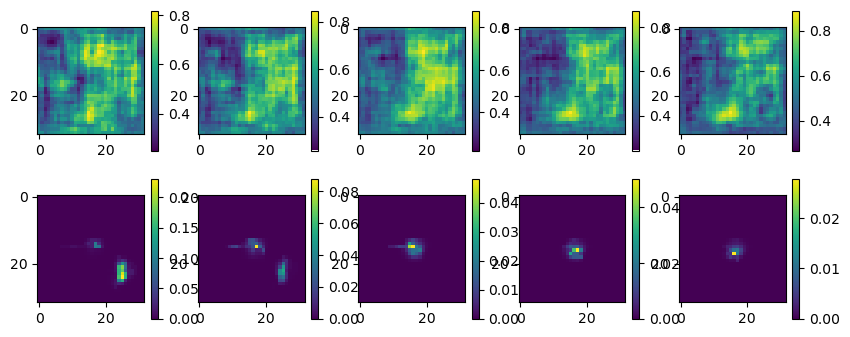

Epoch 10, loss: 0.6586560606956482


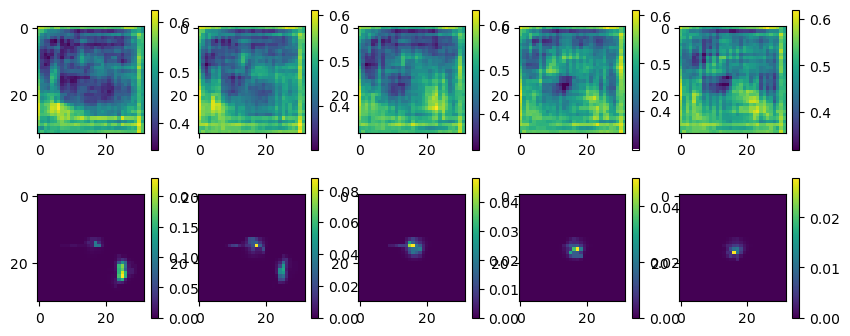

Epoch 20, loss: 0.5800197124481201


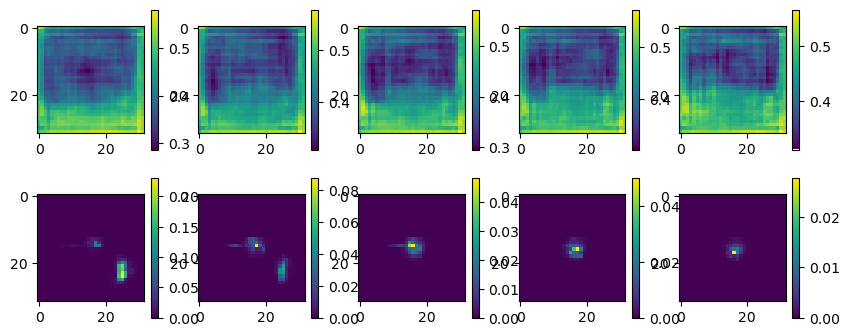

Epoch 30, loss: 0.5457696318626404


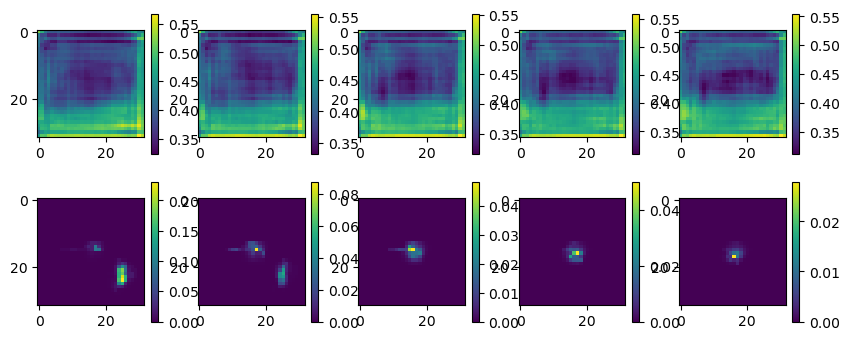

Epoch 40, loss: 0.523112416267395


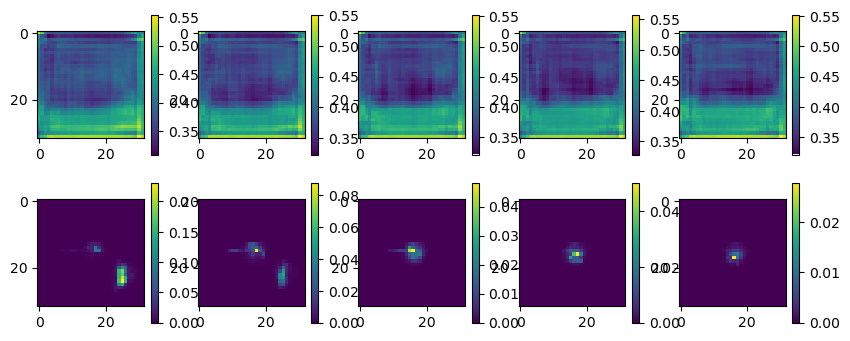

Epoch 50, loss: 0.5034611821174622


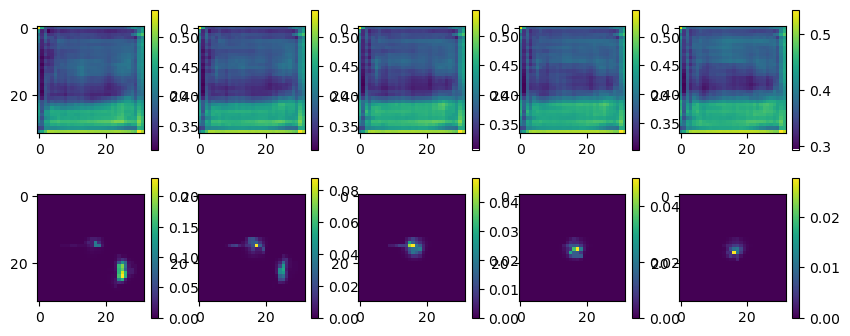

Epoch 60, loss: 0.4851655066013336


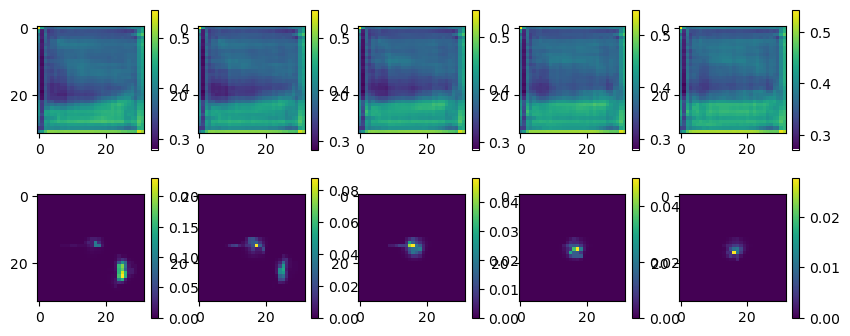

Epoch 70, loss: 0.4670581817626953


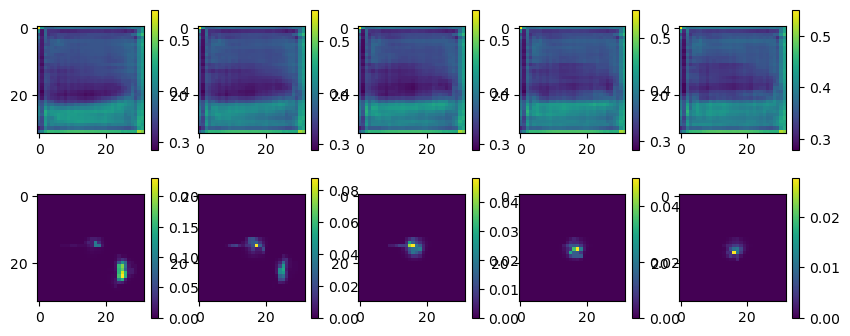

Epoch 80, loss: 0.44947588443756104


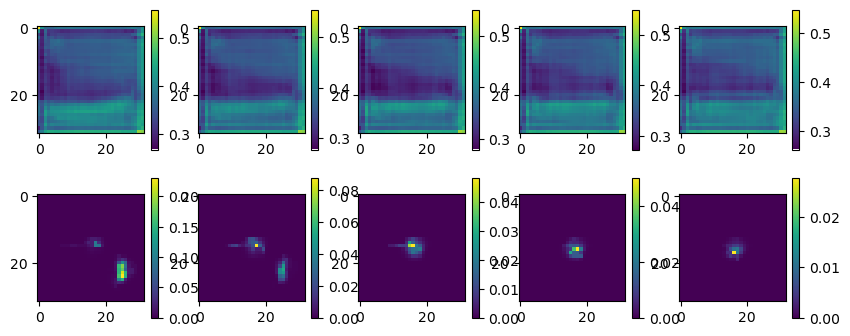

Epoch 90, loss: 0.43253031373023987


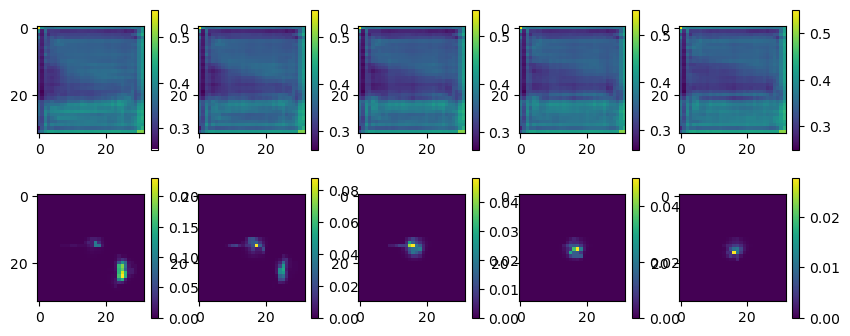

Epoch 100, loss: 0.41593989729881287


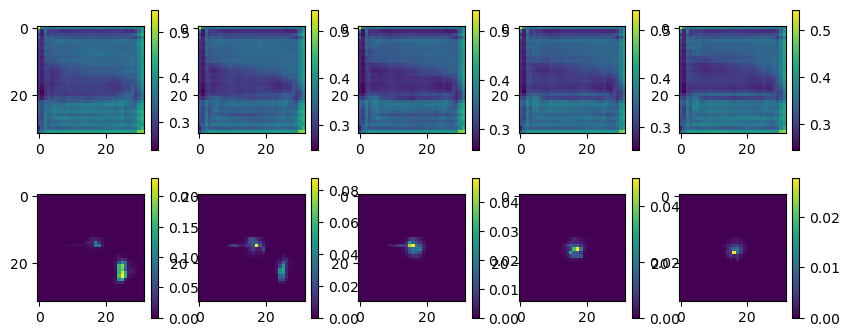

Epoch 110, loss: 0.3994996249675751


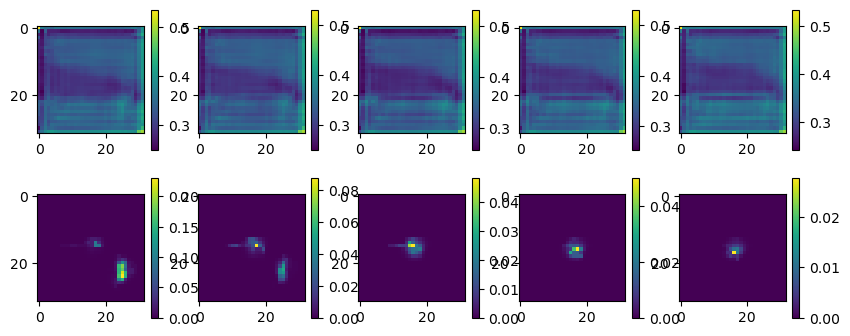

Epoch 120, loss: 0.38302674889564514


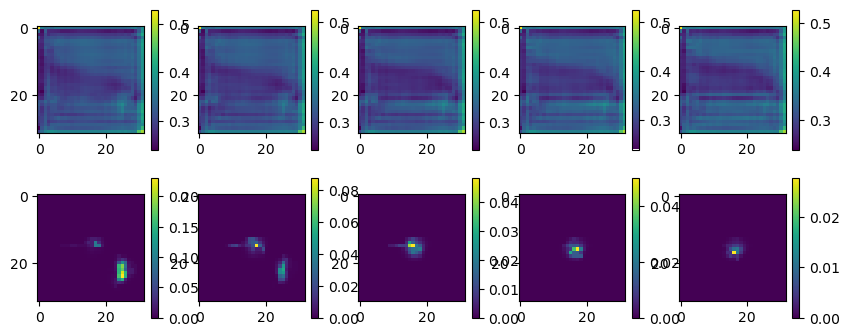

Epoch 130, loss: 0.366361528635025


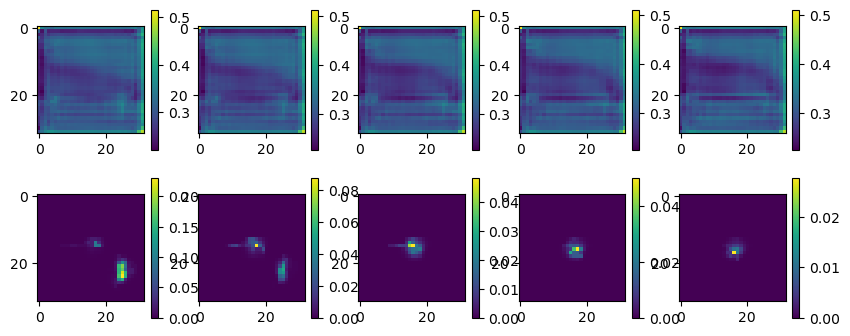

Epoch 140, loss: 0.3493843078613281


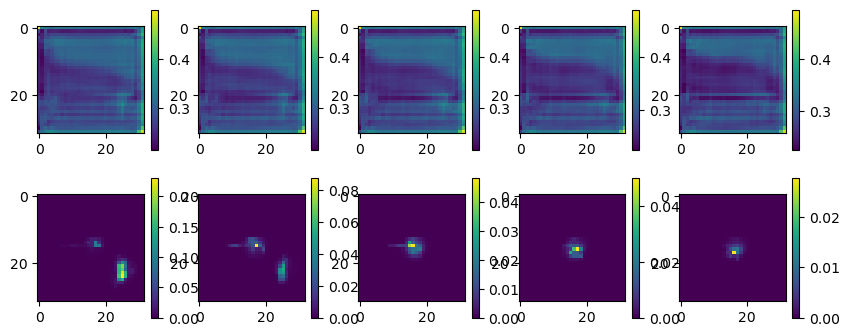

In [15]:
## Here I am using the mode = 'area' in the interpolation
model = VAE_interpolate(in_channels=4, gf_dim=8, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

criterion = torch.nn.BCEWithLogitsLoss()
# Create training loop
model.train()

for epoch in range(150):
    #print(f'Epoch {epoch}')

    optimizer.zero_grad()
    output_dict = model(input_image)
    loss = criterion(output_dict['decoder_output'], label)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss: {loss.item()}')
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        for i in range(5):
            t_ = 10
            mask_1 = ax[0,i].imshow(torch.sigmoid(output_dict['decoder_output'])[0,0,:,:,i+t_].detach().numpy())
            fig.colorbar(mask_1, ax=ax[0,i])
            im = ax[1,i].imshow(anom_mask[0,:,:,i+t_])
            fig.colorbar(im, ax=ax[1,i])
        # Add colorbar
        plt.show()

    


8
Epoch 0, loss: 0.8820540308952332


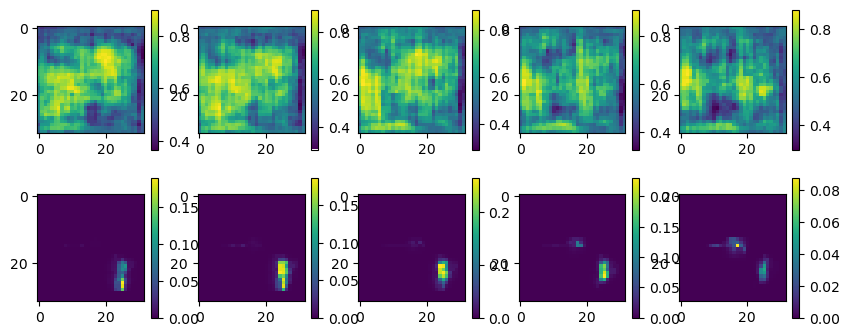

Epoch 10, loss: 0.724513590335846


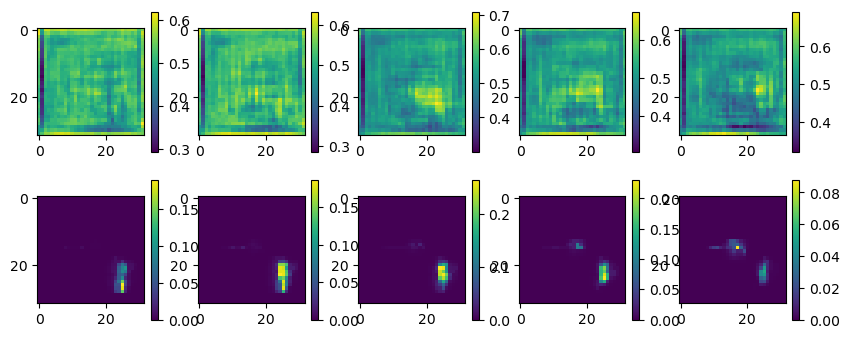

Epoch 20, loss: 0.6638498306274414


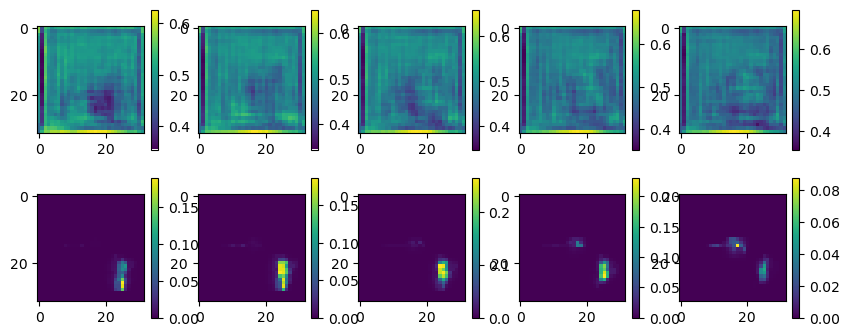

Epoch 30, loss: 0.6268537640571594


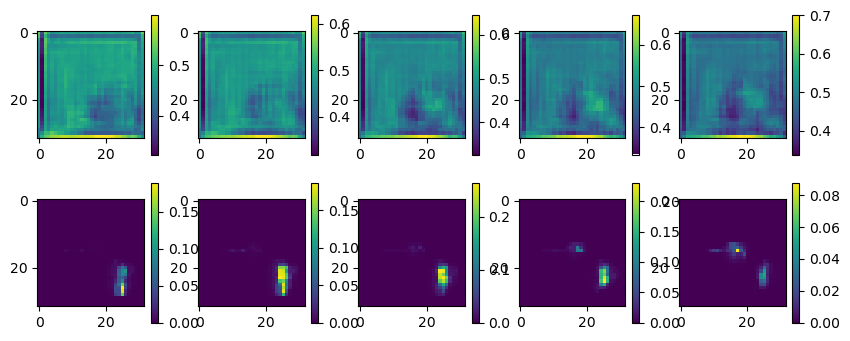

Epoch 40, loss: 0.599369466304779


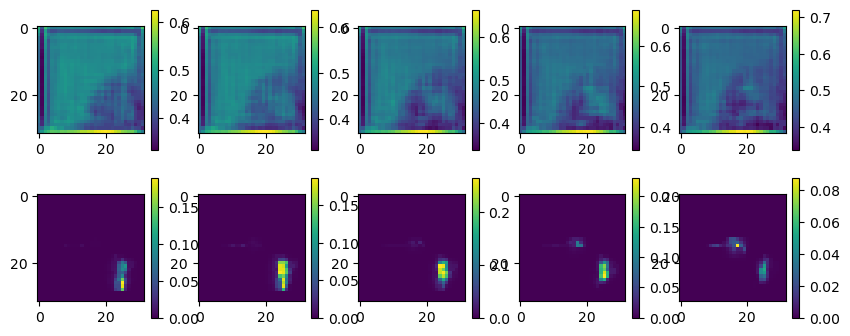

Epoch 50, loss: 0.5759487748146057


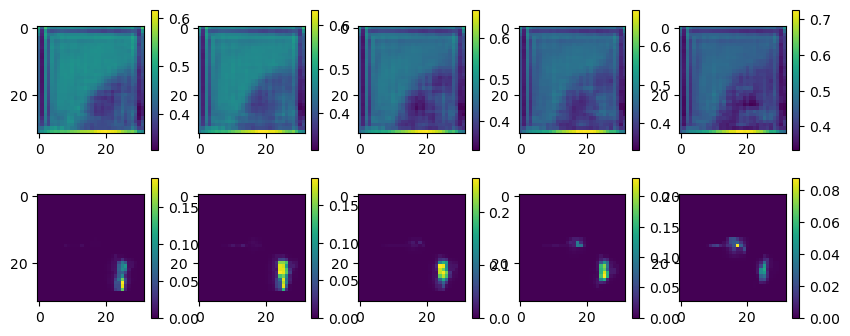

Epoch 60, loss: 0.5552938580513


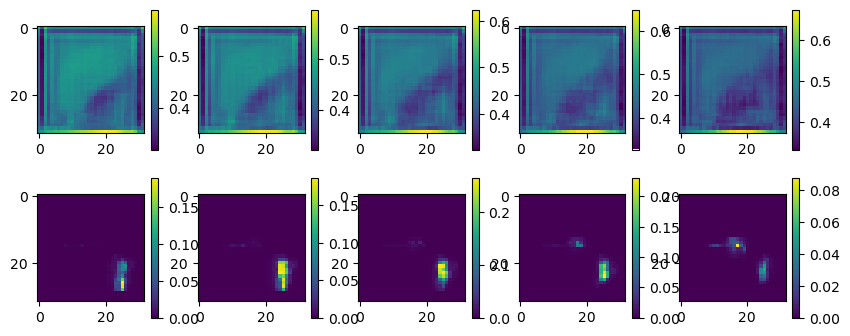

Epoch 70, loss: 0.5361902713775635


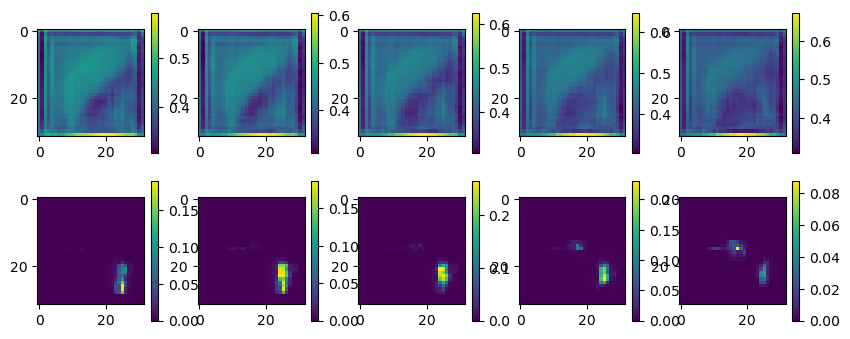

Epoch 80, loss: 0.5177795886993408


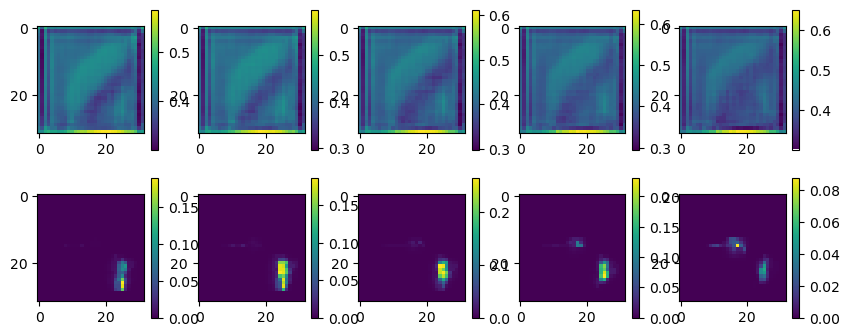

Epoch 90, loss: 0.49942299723625183


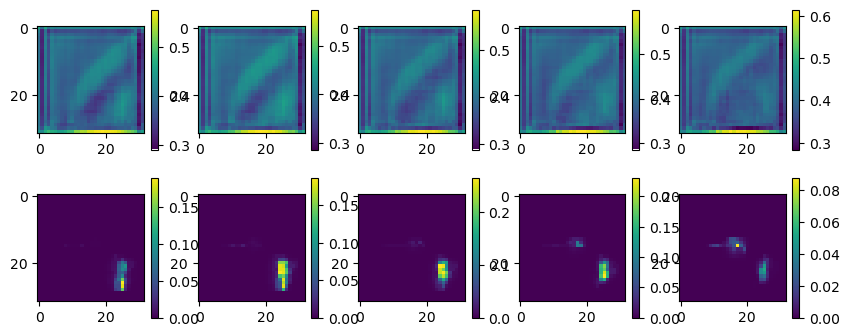

Epoch 100, loss: 0.48109543323516846


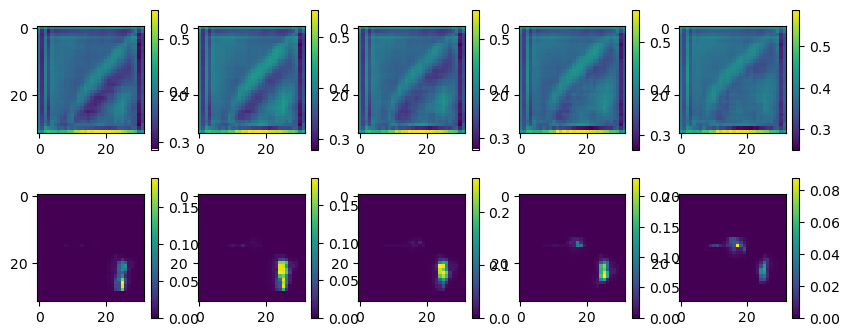

Epoch 110, loss: 0.4622431695461273


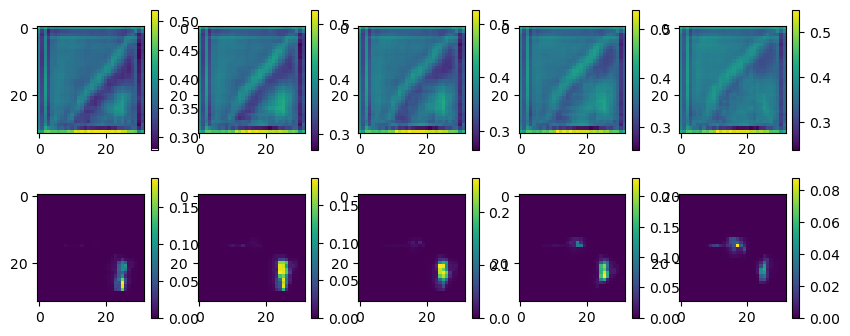

Epoch 120, loss: 0.4421909749507904


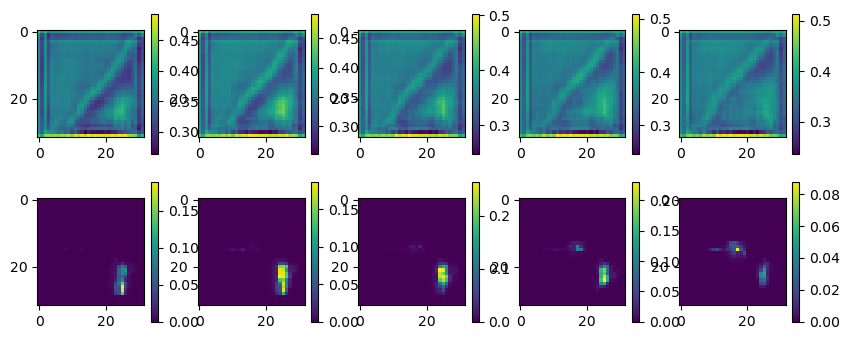

Epoch 130, loss: 0.4212586581707001


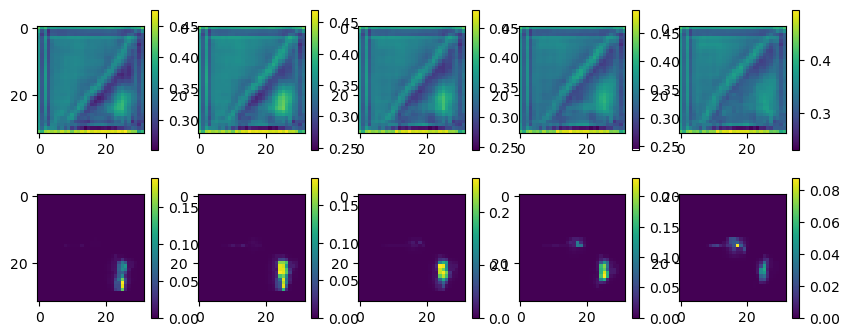

Epoch 140, loss: 0.39990830421447754


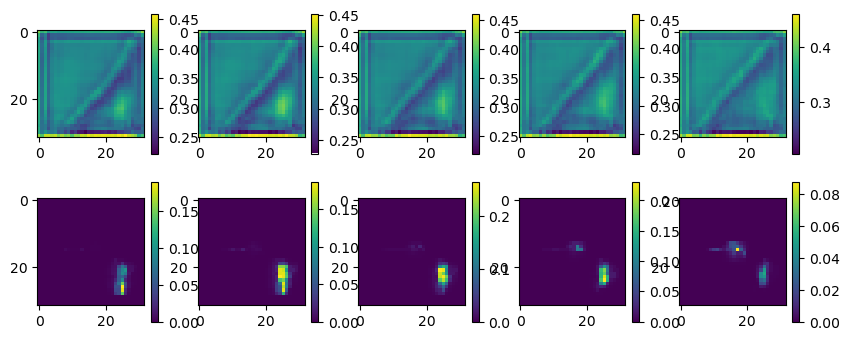

In [20]:
## Here I am using the mode = 'nearest-exact' in the interpolation
model = VAE_interpolate(in_channels=4, gf_dim=8, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

criterion = torch.nn.BCEWithLogitsLoss()
# Create training loop
model.train()

for epoch in range(150):
    #print(f'Epoch {epoch}')

    optimizer.zero_grad()
    output_dict = model(input_image)
    loss = criterion(output_dict['decoder_output'], label)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss: {loss.item()}')
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        for i in range(5):
        
            mask_1 = ax[0,i].imshow(torch.sigmoid(output_dict['decoder_output'])[0,0,:,:,i+t_].detach().numpy())
            fig.colorbar(mask_1, ax=ax[0,i])
            im = ax[1,i].imshow(anom_mask[0,:,:,i+t_])
            fig.colorbar(im, ax=ax[1,i])
        # Add colorbar
        plt.show()

    


8
Epoch 0, loss: 0.7879667282104492


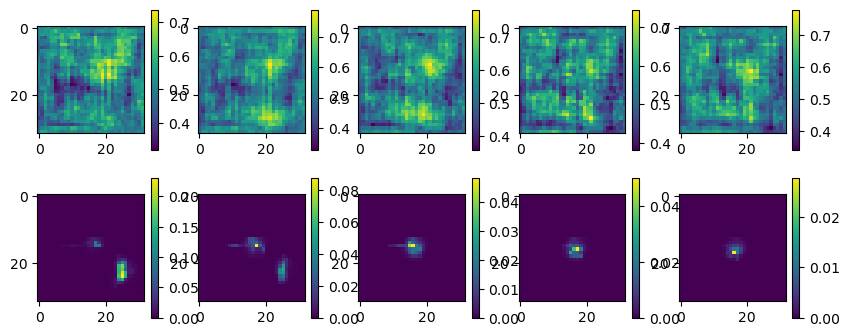

Epoch 10, loss: 0.6589136123657227


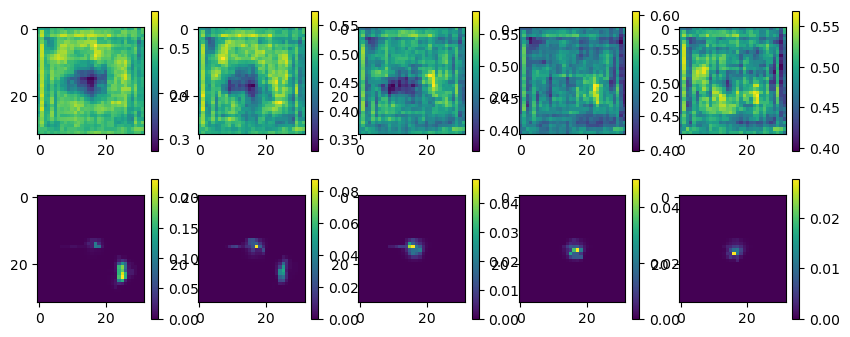

Epoch 20, loss: 0.6104655265808105


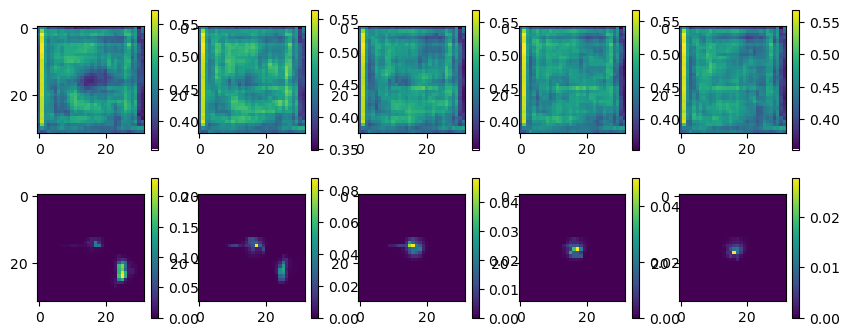

Epoch 30, loss: 0.5825629234313965


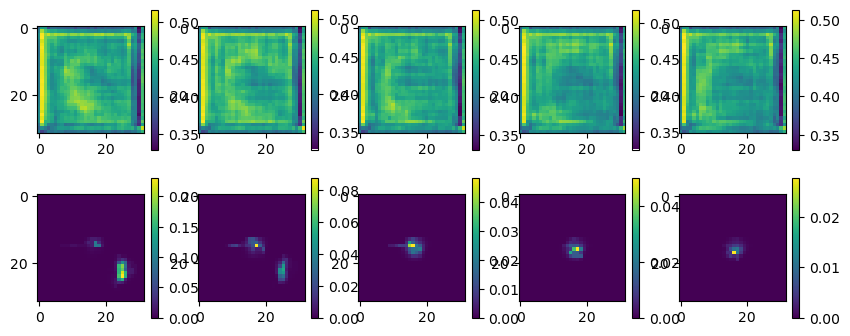

Epoch 40, loss: 0.5580229163169861


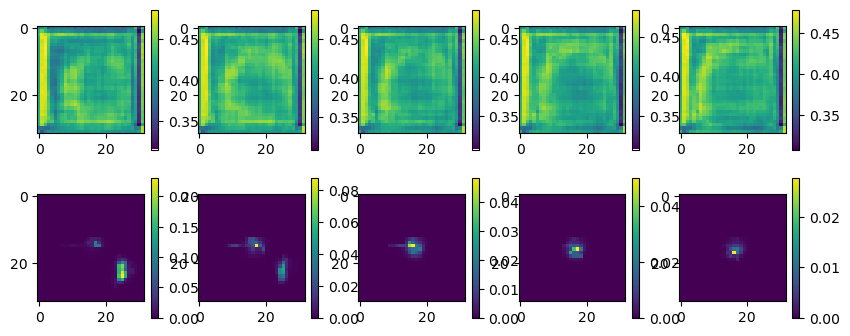

Epoch 50, loss: 0.5340115427970886


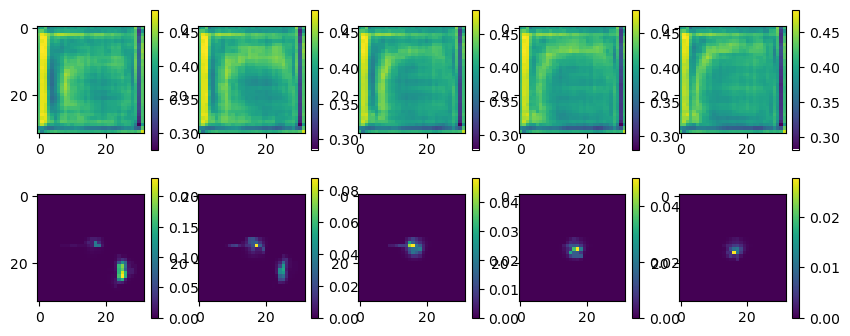

Epoch 60, loss: 0.5099048018455505


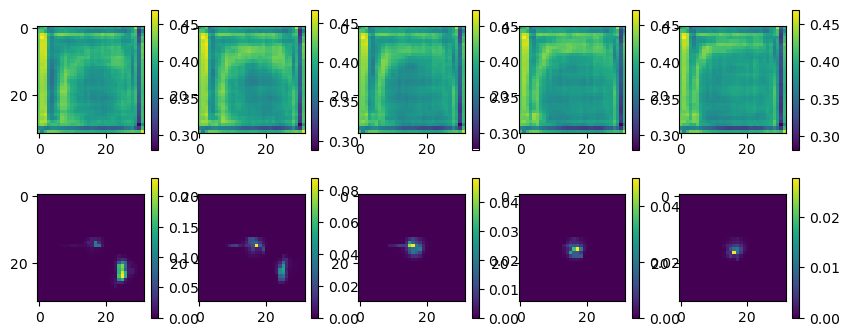

Epoch 70, loss: 0.4861387312412262


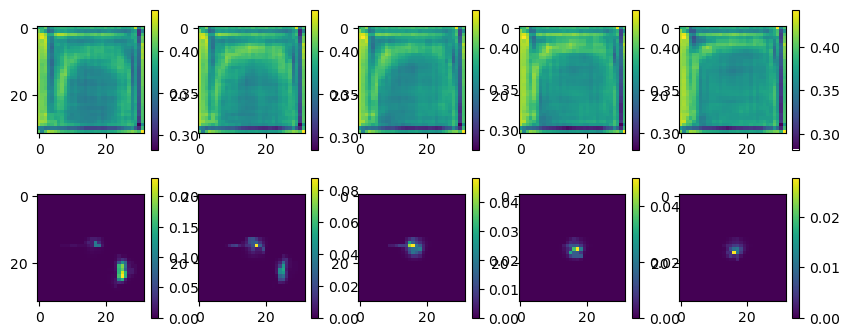

Epoch 80, loss: 0.4629967510700226


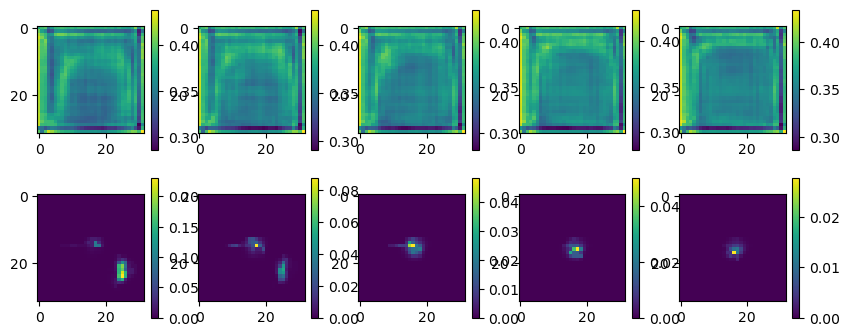

Epoch 90, loss: 0.4402954876422882


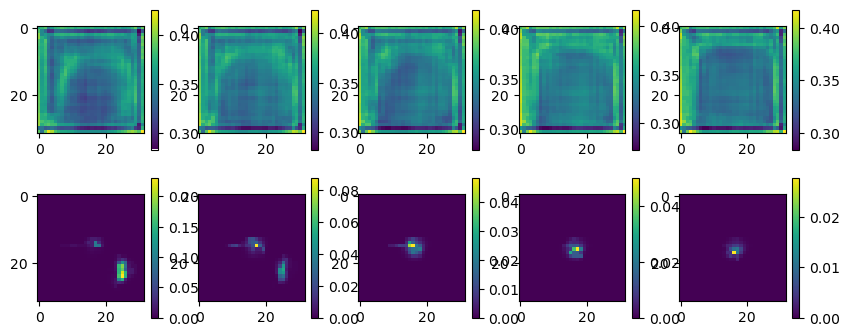

Epoch 100, loss: 0.4182831346988678


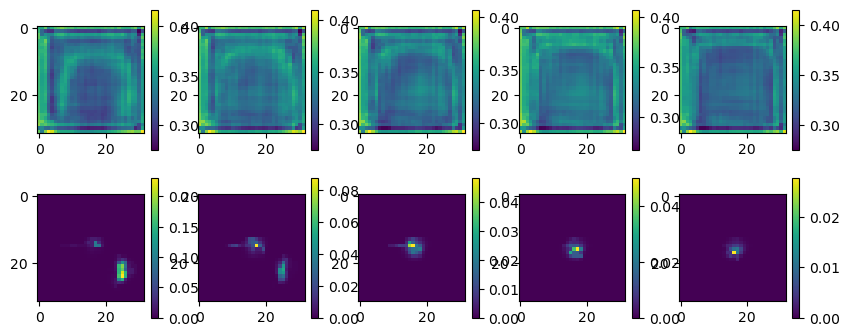

Epoch 110, loss: 0.39729610085487366


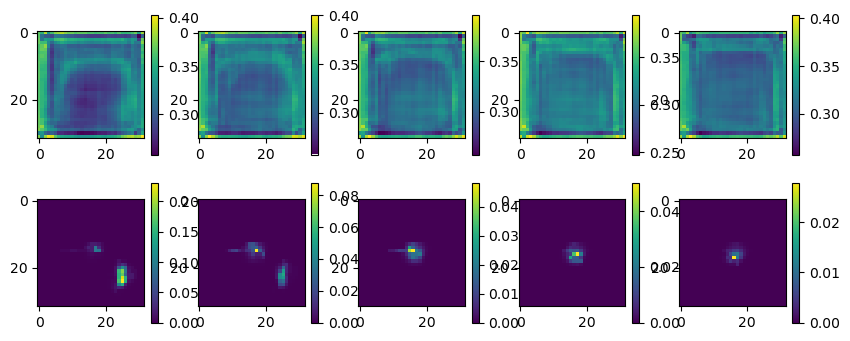

Epoch 120, loss: 0.3773006498813629


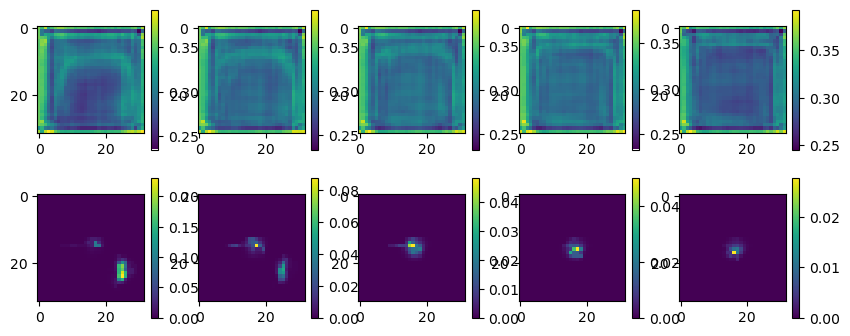

Epoch 130, loss: 0.35816681385040283


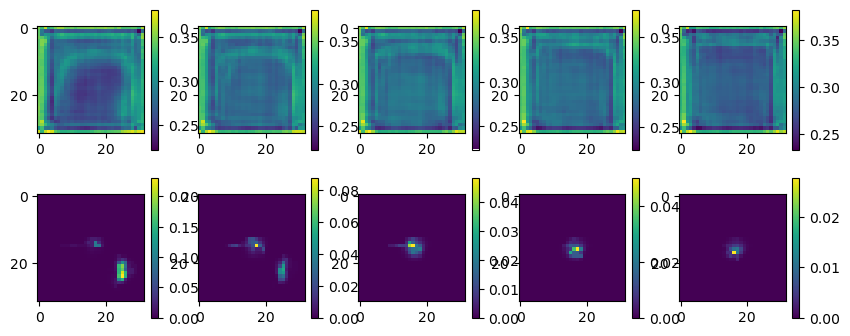

Epoch 140, loss: 0.3396055996417999


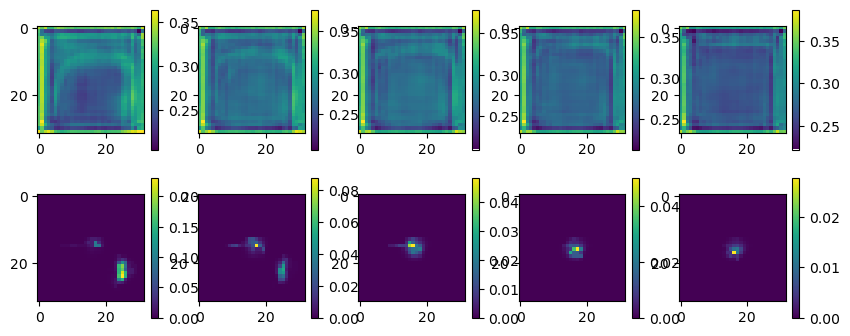

In [22]:
# Try with nearest
model = VAE_interpolate(in_channels=4, gf_dim=8, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

criterion = torch.nn.BCEWithLogitsLoss()
# Create training loop
model.train()

for epoch in range(150):
    #print(f'Epoch {epoch}')

    optimizer.zero_grad()
    output_dict = model(input_image)
    loss = criterion(output_dict['decoder_output'], label)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss: {loss.item()}')
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        for i in range(5):
        
            mask_1 = ax[0,i].imshow(torch.sigmoid(output_dict['decoder_output'])[0,0,:,:,i+t_].detach().numpy())
            fig.colorbar(mask_1, ax=ax[0,i])
            im = ax[1,i].imshow(anom_mask[0,:,:,i+t_])
            fig.colorbar(im, ax=ax[1,i])
        # Add colorbar
        plt.show()

    


8
Epoch 0, loss: 0.7220944762229919


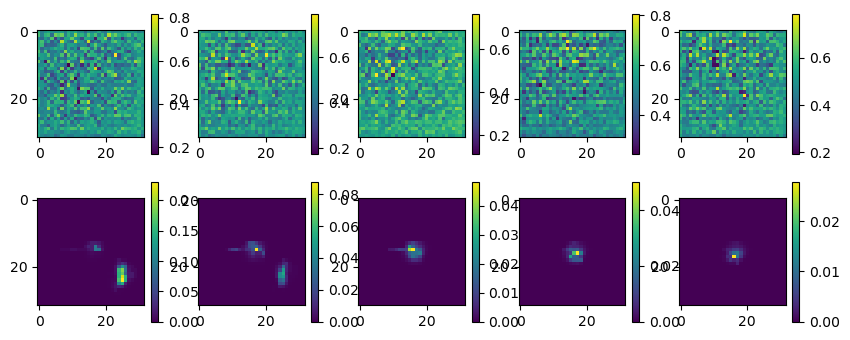

Epoch 10, loss: 0.6469542384147644


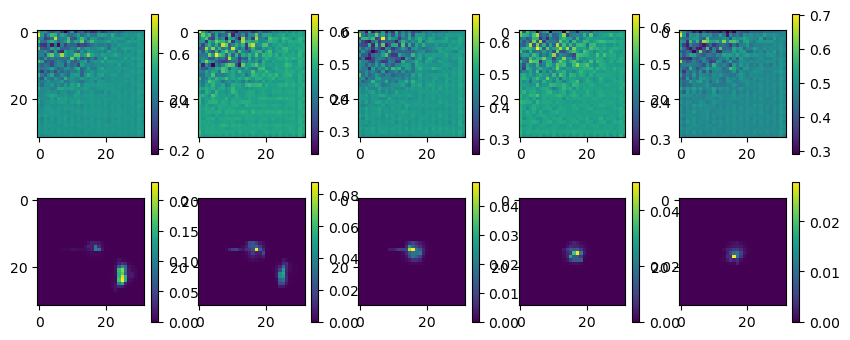

Epoch 20, loss: 0.6070052981376648


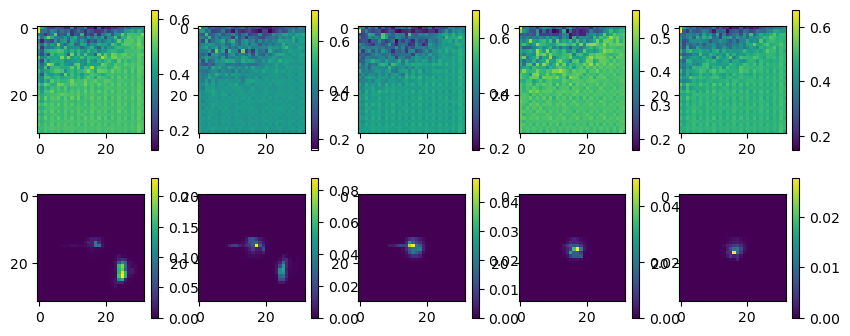

Epoch 30, loss: 0.5681642293930054


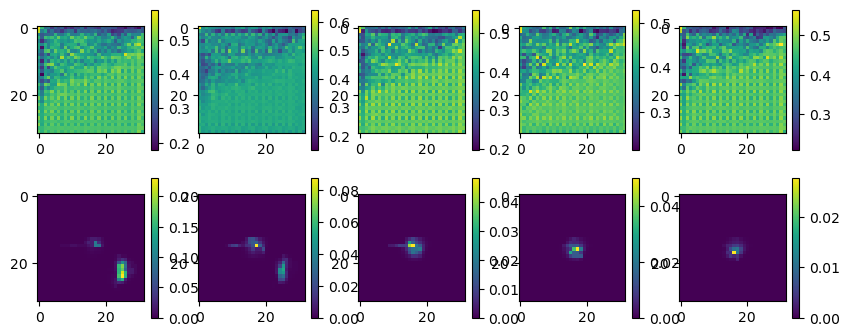

Epoch 40, loss: 0.531215488910675


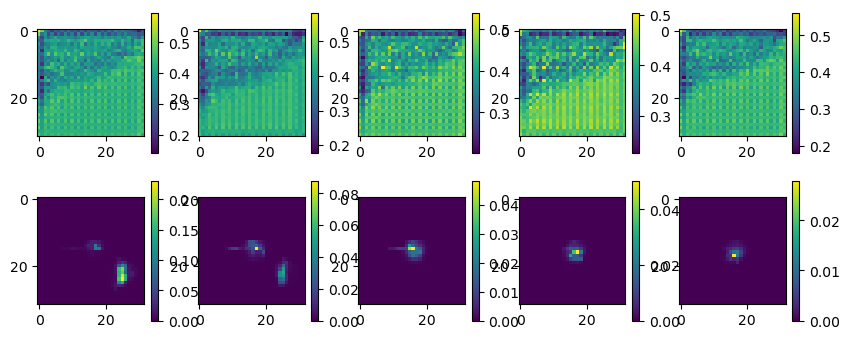

Epoch 50, loss: 0.49692514538764954


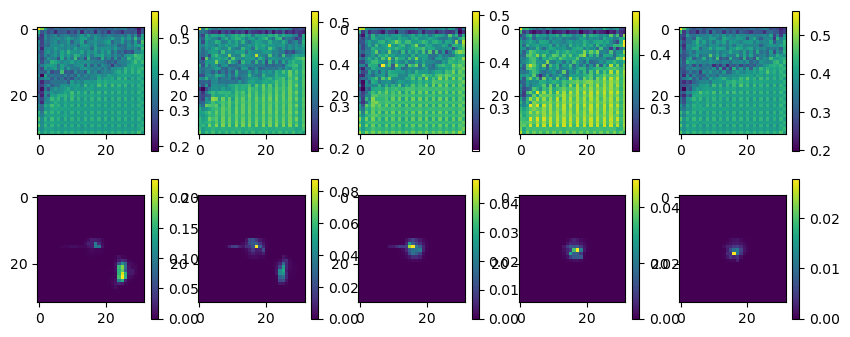

Epoch 60, loss: 0.46588650345802307


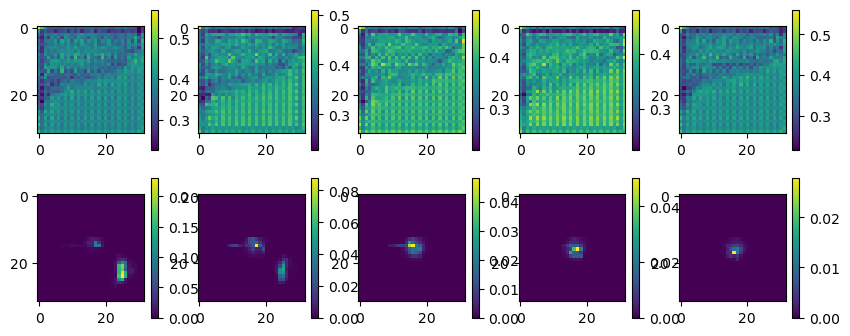

Epoch 70, loss: 0.43771031498908997


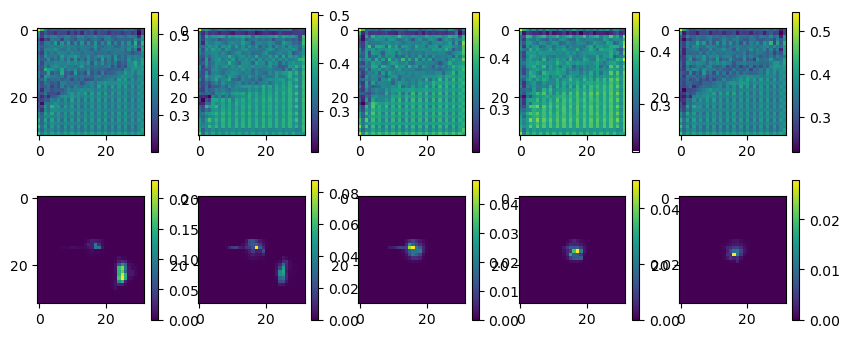

Epoch 80, loss: 0.4114575684070587


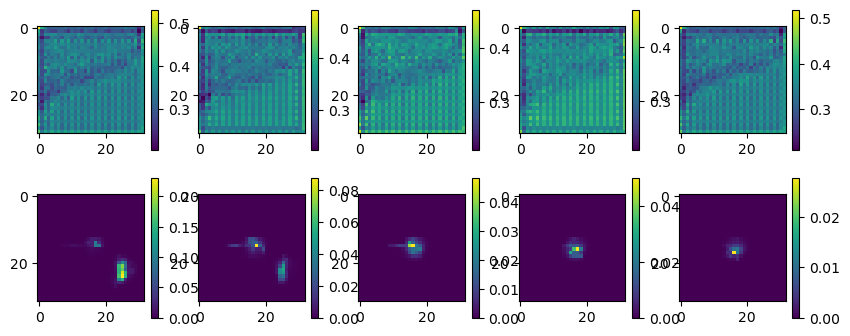

KeyboardInterrupt: 

In [23]:
model = VAE(in_channels=4, gf_dim=8, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

criterion = torch.nn.BCEWithLogitsLoss()
# Create training loop
model.train()

for epoch in range(150):
    #print(f'Epoch {epoch}')

    optimizer.zero_grad()
    output_dict = model(input_image)
    loss = criterion(output_dict['decoder_output'], label)

    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, loss: {loss.item()}')
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        for i in range(5):
        
            mask_1 = ax[0,i].imshow(torch.sigmoid(output_dict['decoder_output'])[0,0,:,:,i+t_].detach().numpy())
            fig.colorbar(mask_1, ax=ax[0,i])
            im = ax[1,i].imshow(anom_mask[0,:,:,i+t_])
            fig.colorbar(im, ax=ax[1,i])
        # Add colorbar
        plt.show()

    


In [ ]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)
    
class Reshape(torch.nn.Module):
    def __init__(self, outer_shape):
        super(Reshape, self).__init__()
        self.outer_shape = outer_shape
    def forward(self, x):
        return x.view(x.size(0), *self.outer_shape)


In [ ]:
def get_flatten_output():
    model = torch.nn.Sequential(
        torch.nn.Conv2d(1, 64, 4, 2),
        torch.nn.LeakyReLU(),
        torch.nn.Conv2d(64, 128, 4, 2),
        torch.nn.LeakyReLU(),
        Flatten(),
    )
    return model(Variable(torch.rand(2,1,28,28))).size()
get_flatten_output()

In [ ]:
def get_reshape_output():
    model = torch.nn.Sequential(
        torch.nn.Linear(2, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 7*7*128),
        torch.nn.ReLU(),
        Reshape((128,7,7,)),
        torch.nn.ConvTranspose2d(128, 64, 4, 2),
        torch.nn.ReLU(),
        torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=3),
        torch.nn.Sigmoid()
    )
    return model(Variable(torch.rand(2,2))).size()
get_reshape_output()

In [ ]:


# Encoder and decoder use the DC-GAN architecture
class Encoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Conv2d(1, 64, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(64, 128, 4, 2, padding=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(6272, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, z_dim)
        ])
        
    def forward(self, x):
        #print("Encoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    
    
class Decoder(torch.nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        self.model = torch.nn.ModuleList([
            torch.nn.Linear(z_dim, 1024),
            torch.nn.ReLU(),
            torch.nn.Linear(1024, 7*7*128),
            torch.nn.ReLU(),
            Reshape((128,7,7,)),
            torch.nn.ConvTranspose2d(128, 64, 4, 2, padding=1),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 4, 2, padding=1),
            torch.nn.Sigmoid()
        ])
        
    def forward(self, x):
        #print("Decoder")
        #print(x.size())
        for layer in self.model:
            x = layer(x)
            #print(x.size())
        return x
    



In [ ]:


def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.shape[1:]
    x = x.unsqueeze(1) # (x_size, 1, dim)
    y = y.unsqueeze(0) # (1, y_size, dim)
    tiled_x = x.expand(x_size, y_size, dim)
    tiled_y = y.expand(x_size, y_size, dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(2)/float(dim)
    return torch.exp(-kernel_input) # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2*xy_kernel.mean()
    return mmd



In [ ]:


class Model(torch.nn.Module):
    def __init__(self, z_dim):
        super(Model, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
        
    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return z, x_reconstructed



In [ ]:


model = Model(2)



In [ ]:

true_samples = torch.rand(100, 2)
z, x_reconstructed = model(Variable(torch.rand(1,1,28,28)))
print(z.size(), x_reconstructed.size(), true_samples.size())

compute_mmd(true_samples, z)



In [ ]:
def compute_kernel(x, y):
    x_size = x.size(0)
    y_size = y.size(0)
    dim = x.size()[1:]  # Get the dimensions of x
    x = x.unsqueeze(1)  # (x_size, 1, *dim)
    y = y.unsqueeze(0)  # (1, y_size, *dim)
    tiled_x = x.expand(x_size, y_size, *dim)
    tiled_y = y.expand(x_size, y_size, *dim)
    kernel_input = (tiled_x - tiled_y).pow(2).mean(dim=2) / float(dim[0])  # Compute mean across the channels
    return torch.exp(-kernel_input)  # (x_size, y_size)

def compute_mmd(x, y):
    x_kernel = compute_kernel(x, x)
    y_kernel = compute_kernel(y, y)
    xy_kernel = compute_kernel(x, y)
    mmd = x_kernel.mean() + y_kernel.mean() - 2 * xy_kernel.mean()
    return mmd
compute_mmd(true_samples, z)

In [ ]:
z = torch.ones(8,256,2,2,3)*100
#true_samples = z.clone()
true_samples = torch.rand(50,256,2,2,3)
x_reconstructed = torch.randn(8,4,32,32,24)
z.size(), x_reconstructed.size()    

compute_mmd(true_samples, z)


In [ ]:
32*8